In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
import seaborn as sns

In [2]:
housing = pd.read_csv("housing.csv")

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


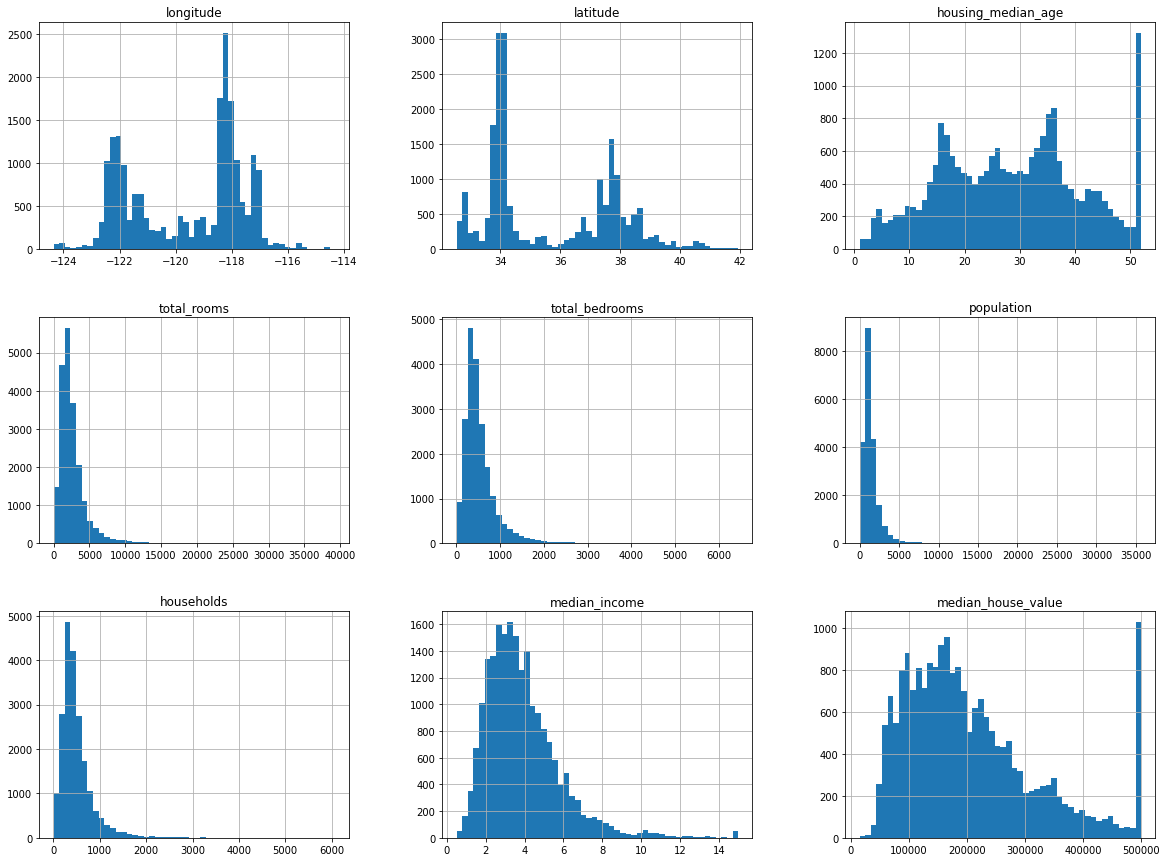

In [7]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

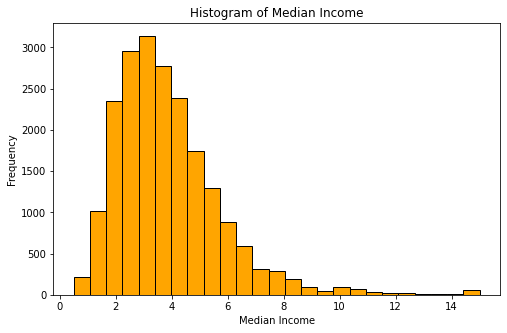

In [8]:
# Another way
fig = plt.figure(figsize=(8, 5))
plt.hist(data=housing, x='median_income', bins=25, edgecolor = 'black', color='orange')
plt.xlabel('Median Income')
plt.ylabel('Frequency')
plt.title('Histogram of Median Income')
plt.show()

### Create a Test Set

In [9]:
# To have the output of train and test data set identical on very run
np.random.seed(42)

In [10]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)

In [12]:
len(train_set)

16512

In [13]:
len(test_set)

4128

### Having a stable train and test set while fetching an updated dataset

In [14]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [15]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [16]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [17]:
# Another way of creating ID
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [18]:
# Simplest way to split you train and test data set
train_set, test_set = train_test_split(housing, test_size=0.2, 
                                       random_state=42)

In [19]:
# Creating a column named "income_cat"

In [20]:
housing["income_cat"] = pd.cut(housing['median_income'], 
                               bins=[0.0, 1.5, 3.0, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

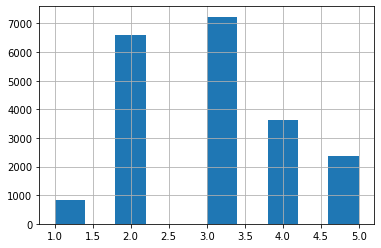

In [21]:
housing['income_cat'].hist()
plt.show()

### Stratified sampling based on the income category

In [22]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [23]:
(strat_test_set['income_cat'].value_counts() / len(strat_test_set) * 100).sort_index()

1     3.997093
2    31.879845
3    35.053295
4    17.635659
5    11.434109
Name: income_cat, dtype: float64

In [24]:
# Comparing random sampling with stratified sampling
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [25]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [26]:
# Removing the income_cat attribute so the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [27]:
# Creating a copy

In [28]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

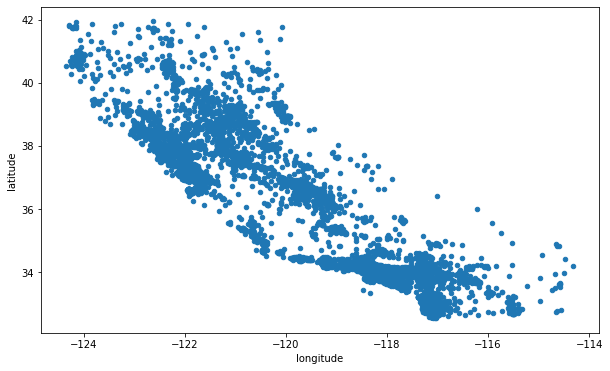

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,6))
plt.show()

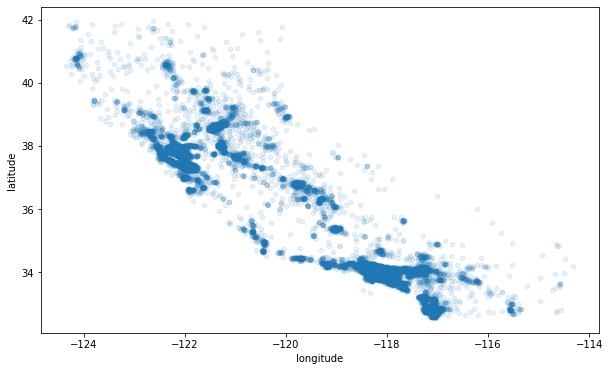

In [30]:
# Visualizing the places where there is a high density of data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, 
             figsize=(10,6))
plt.show()

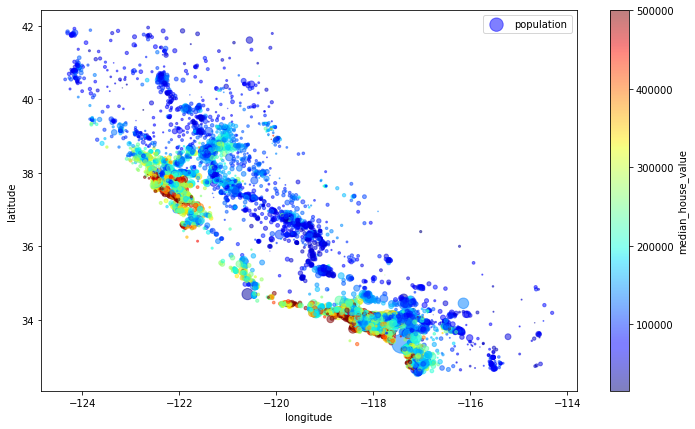

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude",
             s=housing["population"]/100, alpha=0.5, 
             label="population", figsize=(12,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), 
             colorbar=True, sharex=False)

plt.legend()
plt.show()

### Looking for Correlations

In [32]:
corr_matrix = housing.corr()

In [33]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

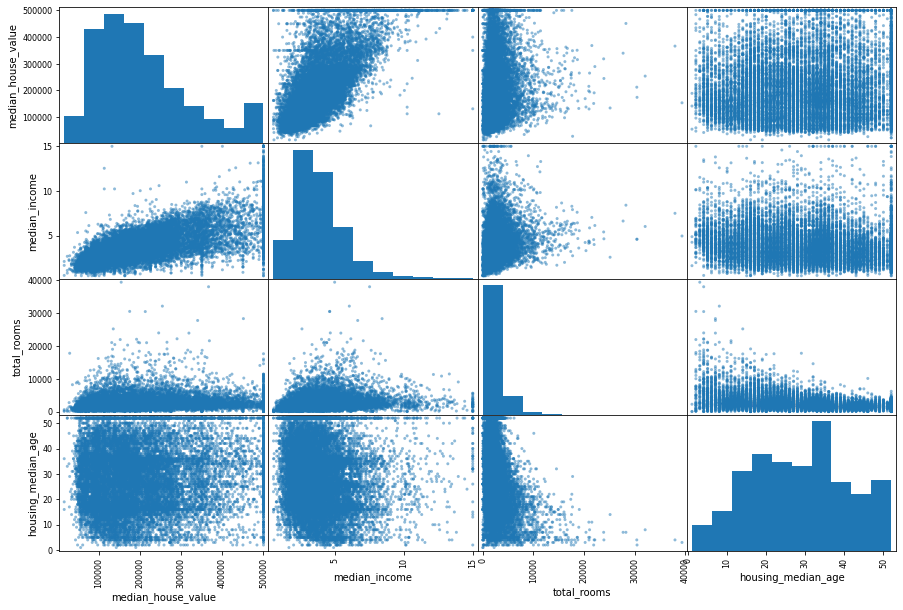

In [34]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(15,10))
plt.show()

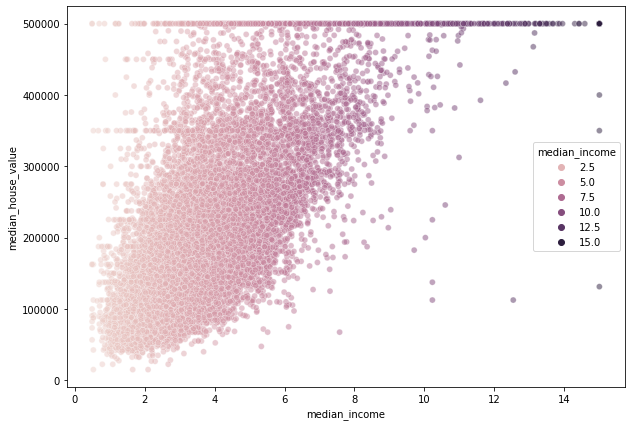

In [35]:
# Correlation scatterplot between median_income and median_house_value
plt.figure(figsize=(10,7))
sns.scatterplot(data=housing, x='median_income', y='median_house_value',
                alpha=0.5, hue="median_income")
plt.show()


### Experimenting with Attribute Combinations

In [36]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedroom_per_room"] = housing["total_rooms"] / housing["total_bedrooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [37]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedroom_per_room,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,4.859473,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,6.927083,6.222222,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,5.219355,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,3.886128,3.616570,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,6.096552,5.473684,3.167241


In [38]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
bedroom_per_room            0.385233
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
Name: median_house_value, dtype: float64

### Prepare the Data for Machine Learning Algorithms

In [39]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Data Cleaning

In [40]:
median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)

In [41]:
# Using SimpleImputer with strategy "median" to replace NAN values 
imputer = SimpleImputer(strategy="median")

In [42]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [43]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [44]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [45]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [46]:
X = imputer.transform(housing_num)

In [47]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, 
                          index=housing_num.index)

In [48]:
housing_tr.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

### Handling Text and Categorical Attributes

In [49]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [50]:
# OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [51]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [52]:
# OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [53]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [54]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

In [55]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [56]:
from sklearn.base import BaseEstimator, TransformerMixin

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        room_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, rooms_ix] / X[:, bedrooms_ix]
            return np.c_[X, room_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, room_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [57]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", 
                                   "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


### Transformation Pipelines

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [59]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.10981321],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077,  0.99365508],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122,  0.18159637],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619, -0.59600909],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604,  0.35998168],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.1090947 ]])

In [60]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num.columns)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)


In [61]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

### Select and Train a Model

#### Training and Evaluating on the Training Set

##### Using LinearRegression

In [62]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [63]:
housing_labels

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
           ...   
15174    268500.0
12661     90400.0
19263    140400.0
19140    258100.0
19773     62700.0
Name: median_house_value, Length: 16512, dtype: float64

In [64]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [65]:
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85568. 306336. 151968. 186560. 245376.]


In [66]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [67]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68724.1874571864

In [68]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49676.053112887595

##### Using DecisionTreeRegressor

In [69]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [70]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [71]:
housing_predictions

array([ 72100., 279600.,  82700., ..., 140400., 258100.,  62700.])

In [72]:
print("Predictions:", tree_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 72100. 279600.  82700. 112500. 238300.]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


#### Evaluation Using Cross-Validation

##### Using train test split() function

In [73]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [74]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [73361.56127649 72425.69613875 68473.18178431 71779.31785269
 70331.00541722 76614.19374711 70223.28942734 72600.53409986
 69732.21118043 70826.92397287]
Mean: 71636.79148970799
Standard deviation: 2175.216114372284


In [75]:
# Scores of Linear Regression model

In [76]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=10)
lin_rmse_score = np.sqrt(-lin_scores)
display_scores(lin_rmse_score)

Scores: [72078.27918912 64201.68142793 68412.15263848 69213.61438203
 67014.95989154 72558.39782846 70320.67497973 68985.51633436
 66748.87079811 70564.71142842]
Mean: 69009.88588981806
Standard deviation: 2423.8968265157564


##### Using Random Forest Regressor

In [77]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [78]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18657.124841059078

In [80]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51585.44989531 48640.53233316 47127.49869972 51916.05352472
 47635.61663093 51886.19809785 52482.02913174 49827.19270575
 48695.36576371 54130.55950193]
Mean: 50392.64962848164
Standard deviation: 2210.0806879258803


### Fine-Tuning the Model

#### Grid Search

In [82]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators': [3,10], 'max_features':[2,3,4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [83]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [84]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [85]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63691.37078934853 {'max_features': 2, 'n_estimators': 3}
55458.06854326977 {'max_features': 2, 'n_estimators': 10}
52659.58771877503 {'max_features': 2, 'n_estimators': 30}
60881.33696689004 {'max_features': 4, 'n_estimators': 3}
53109.423346013245 {'max_features': 4, 'n_estimators': 10}
50552.66044990482 {'max_features': 4, 'n_estimators': 30}
59104.27116322911 {'max_features': 6, 'n_estimators': 3}
52273.03434420179 {'max_features': 6, 'n_estimators': 10}
50253.8992266129 {'max_features': 6, 'n_estimators': 30}
58459.46428463963 {'max_features': 8, 'n_estimators': 3}
52288.44129738831 {'max_features': 8, 'n_estimators': 10}
50270.91093848565 {'max_features': 8, 'n_estimators': 30}
61200.797655738446 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54183.17402328686 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60357.46945166962 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52916.267749995095 {'bootstrap': False, 'max_features': 3, 'n_estimators': 